In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Pairwise Power Spectrum Estimators
This notebook computes the pairwise power spectrum and 2PCF estimators using both the midpoint and bisector line-of-sight definitions. This is done for either the BOSS 'low-z ngc' dataset or equivalent MultiDark-Patchy mocks. The pairwise estimators use the coupling coefficients computed in the ```Beyond Yamamoto Coefficients``` notebook.

Note that this is by no means an optimal implementation, and requires a large memory usage if run at high-resolution.

**Dependencies:**
- python2 or python3
- pyfftw
- nbodykit
- sympy

In [2]:
import sys, os, copy, time, pyfftw
import numpy as np
from nbodykit.lab import *
from nbodykit import setup_logging, style
import sympy as sp

### 0) Input Parameters

In [3]:
# Simulation number (set to -1 for BOSS data)
sim_no = 101

grid_factor = 2 # factor by which to reduce grid size relative to the original BOSS release
threads = 4 # CPUs
MAS = 'TSC' # Mass assignment scheme
patch = 'ngc' # ngc or sgc

# Redshift ranges
ZMIN = 0.2
ZMAX = 0.5

# FKP weight
P_fkp = 1e4

# k and ell binning
kmin = 0.005
kmax = 0.25
dk = 0.01
l_max = 4

# maximum order of midpoint and bisector corrections
alpha_max = 4
k_bis_max = 2

# Box and grid-size
# NB: should double this for the Pk-midpoint estimator
boxsize_grid = np.array([1350,2450,1400])
grid_3d = np.asarray(np.asarray([252,460,260],dtype=int)/grid_factor,dtype=int)

# Cosmology for co-ordinate conversions
cosmo = cosmology.Cosmology(h=0.676).match(Omega0_m=0.31)

### 1) Load in (data-randoms) density field 

In [4]:
### 1: LOAD IN (DATA-RANDOMS) DENSITY FIELD
print("\n1: LOAD IN DATA\n")
if sim_no==-1:
    dat_dir = '/tigress/ophilcox/patchy_ngc_mocks/ngc_mocks/'

    # BOSS FITS File
    datfile = '/projects/QUIJOTE/Oliver/boss_gal/galaxy_DR12v5_CMASSLOWZTOT_North.fits'
    data = FITSCatalog(datfile)
else:
    # Patchy input
    dat_dir = '/tigress/ophilcox/patchy_ngc_mocks/ngc_mocks/'
    datfile = dat_dir+'Patchy-Mocks-DR12NGC-COMPSAM_V6C_%s.dat'%str(sim_no).zfill(4)
    data = CSVCatalog(datfile,['RA', 'DEC', 'Z', 'MSTAR', 'NBAR', 'BIAS', 'VETO FLAG', 'FIBER COLLISION'])

valid = (data['Z'] > ZMIN)&(data['Z'] < ZMAX)
data = data[valid]

print("Loaded %d galaxies from simulation %d \n"%(len(data),sim_no))

# Convert to Cartesian co-ordinates using the fiducial cosmology
data['Position'] = transform.SkyToCartesian(data['RA'], data['DEC'], data['Z'], cosmo=cosmo)

if sim_no==-1:
    # Add completeness + systematic weights
    data['WEIGHT'] = data['WEIGHT_SYSTOT'] * (data['WEIGHT_NOZ'] + data['WEIGHT_CP'] - 1.)
    data['NBAR'] = data['NZ']
else:
    # Add the completeness weights
    data['WEIGHT'] = 1.* data['VETO FLAG'] * data['FIBER COLLISION']

data['WEIGHT_FKP'] = 1./(1.+data['NBAR']*P_fkp)

### LOAD RANDOMS

if sim_no!=-1:
    randfile = '/tigress/ophilcox/patchy_ngc_mocks/Patchy-Mocks-Randoms-DR12NGC-COMPSAM_V6C_x50.dat'
    randoms = CSVCatalog(randfile,['RA', 'DEC', 'Z', 'NBAR', 'BIAS', 'VETO FLAG', 'FIBER COLLISION'])
else:
    randfile = '/projects/QUIJOTE/Oliver/boss_gal/random0_DR12v5_CMASSLOWZTOT_North.fits'
    randoms = FITSCatalog(randfile)

# Cut to required redshift range
valid = (randoms['Z'] > ZMIN)&(randoms['Z'] < ZMAX)
randoms = randoms[valid]

print("Loaded %d randoms \n"%len(randoms))

# Convert to Cartesian co-ordinates using the fiducial cosmology
randoms['Position'] = transform.SkyToCartesian(randoms['RA'], randoms['DEC'], randoms['Z'], cosmo=cosmo)

if sim_no==-1:
    randoms['WEIGHT'] = np.ones_like(randoms['Weight'])*1. # all unity here
    randoms['NBAR'] = randoms['NZ']
else:
    randoms['WEIGHT'] = np.ones_like(randoms['VETO FLAG'])*1. 

randoms['WEIGHT_FKP'] = 1./(1.+randoms['NBAR']*P_fkp)


1: LOAD IN DATA

Loaded 480707 galaxies from simulation 101 

Loaded 23818339 randoms 



### 2) Paint to mesh

In [5]:
# 2) PAINT TO MESH
# combine the data and randoms into a single catalog
fkp = FKPCatalog(data, randoms,BoxSize=boxsize_grid,
                 nbar='NBAR')

assert MAS=='TSC'
mesh = fkp.to_mesh(Nmesh=grid_3d,nbar='NZ', fkp_weight='WEIGHT_FKP', comp_weight='WEIGHT', window='tsc')

from pmesh.pm import ComplexField,RealField
from nbodykit.algorithms.fftpower import project_to_basis, _find_unique_edges

### Extract [n_g - n_r]w density field, and normalize
alpha_norm = np.sum(data['WEIGHT'])/np.sum(randoms['WEIGHT'])
norm = 1./np.asarray(alpha_norm*np.sum(randoms['NBAR']*randoms['WEIGHT']*randoms['WEIGHT_FKP']**2.))

Sdat = (data['WEIGHT']**2*data['WEIGHT_FKP']**2.).sum()
Sran = (randoms['WEIGHT']**2.*randoms['WEIGHT_FKP']**2.).sum()*alpha_norm**2.
Pshot = np.asarray(Sdat+Sran)*norm

def get_compensation(mesh):
    toret = None
    try:
        compensation = mesh._get_compensation()
        toret = {'func':compensation[0][1], 'kind':compensation[0][2]}
    except ValueError:
        pass
    return toret

### SET UP FIELDS AND OUTPUT
first = mesh
second = mesh

# clear compensation from the actions
for source in [first, second]:
    source.actions[:] = []; source.compensated = False
    assert len(source.actions) == 0

# compute the compensations
compensation = {}
for name, mesh in zip(['first', 'second'], [first, second]):
    compensation[name] = get_compensation(mesh)

pm   = first.pm

# paint the 1st FKP density field to the mesh (paints: data - alpha*randoms, essentially)
density = first.compute(Nmesh=pm.Nmesh)

# This is the output density field we'll use later
diff = density.copy().value

### 2b) Set-Up Functions

In [6]:
# Fourier-space coordinate grid
kF = 2.*np.pi/(1.*boxsize_grid)
middle_3d = np.asarray(grid_3d)/2
kx, ky, kz = [np.asarray([kkk-grid_3d[i] if kkk>=middle_3d[i] else kkk for kkk in xrange(grid_3d[i])])*kF[i] for i in range(3)]
kNy = kF*grid_3d/2.
k3y,k3x,k3z = np.meshgrid(ky,kx,kz)
k3D = np.sqrt(k3x**2.+k3y**2.+k3z**2.)
print("k_Nyquist = %.2f h/Mpc"%kNy.mean())

# Delta coordinate grid
Deltax_grid, Deltay_grid, Deltaz_grid = [density.x[i].ravel() for i in range(3)]
D3y,D3x,D3z = np.meshgrid(Deltay_grid,Deltax_grid,Deltaz_grid)
Delta_all = np.sqrt(D3x**2.+D3y**2.+D3z**2.)

# the real-space grid of r1 or r2
offset = first.attrs['BoxCenter'] + 0.5*pm.BoxSize / pm.Nmesh
x_grid,y_grid,z_grid = [xx.astype('f8').ravel() + offset[ii] for ii, xx in enumerate(density.slabs.optx)]
r3y,r3x,r3z = np.meshgrid(y_grid,x_grid,z_grid)
r_all = np.sqrt(r3x**2.+r3y**2.+r3z**2.)

# Compute the Y_lm vectors (complex)
def get_Ylm(l, m):
    """
    Return a function that computes the complex spherical harmonic of order (l,m). Adapted from nbodykit
    """

    # make sure l,m are integers
    l = int(l); m = int(m)

    # the relevant cartesian and spherical symbols
    x, y, z, r = sp.symbols('x y z r', real=True, positive=True)
    xhat, yhat, zhat = sp.symbols('xhat yhat zhat', real=True, positive=True)
    phi, theta = sp.symbols('phi theta')
    defs = [(sp.sin(phi), y/sp.sqrt(x**2+y**2)),
            (sp.cos(phi), x/sp.sqrt(x**2+y**2)),
            (sp.cos(theta), z/sp.sqrt(x**2 + y**2+z**2))]

    # the normalization factors
    if m == 0:
        amp = sp.sqrt((2*l+1) / (4*numpy.pi))
    else:
        amp = sp.sqrt((2*l+1) / (4*numpy.pi) * sp.factorial(l-m) / sp.factorial(l+m))

    # the cos(theta) dependence encoded by the associated Legendre poly
    expr = sp.assoc_legendre(l, m, sp.cos(theta))

    # the phi dependence
    expr *= sp.expand_trig(sp.cos(m*phi)+1j*sp.sin(m*phi))

    # simplify
    expr = sp.together(expr.subs(defs)).subs(x**2 + y**2 + z**2, r**2)
    expr = amp * expr.expand().subs([(x/r, xhat), (y/r, yhat), (z/r, zhat)])
    Ylm = sp.lambdify((xhat,yhat,zhat), expr, 'numexpr')

    # attach some meta-data
    Ylm.expr = expr
    Ylm.l    = l
    Ylm.m    = m

    return Ylm

def compute_Ylm_complex(x,y,z,lmax):
    """Compute Y_lm(\hat{r}) for ell = 0, 2
    x,y,z are normalized direction vectors.

    NB: Using Cartesian definitions from Wikipedia
    """

    Y_lm_out = []
    for l in np.arange(0,lmax+1,1):
        Y_m_out = []
        for m in np.arange(-l,l+1,1):
            Y_m_out.append(0.*x+get_Ylm(l,m)(x,y,z))
        Y_lm_out.append(np.asarray(Y_m_out))
    return Y_lm_out

def vechat(k,k_norm):
    """Compute k_i / |k| being careful of the |k| = 0 case"""
    khat = np.zeros_like(k)
    filt = k_norm!=0.
    khat[filt] = k[filt]/k_norm[filt]
    return khat

# Compute spherical harmonics
# NB: it is not memory efficient to hold all these in memory, but it is fast
print("Computing spherical harmonics")
Yk_lm_3D = compute_Ylm_complex(vechat(k3x,k3D),vechat(k3y,k3D),vechat(k3z,k3D),lmax=l_max)
Y_lm_grid = compute_Ylm_complex(vechat(r3x,r_all),vechat(r3y,r_all),vechat(r3z,r_all),lmax=l_max+alpha_max)
YDelta_lm_grid = compute_Ylm_complex(vechat(D3x,Delta_all),vechat(D3y,Delta_all),vechat(D3z,Delta_all),lmax=l_max+alpha_max)

print("Computing mass asssignment weights")

assert MAS=='TSC'

# using nbodykit scheme (including first-order aliasing correction)
prefact = np.pi/np.asarray(grid_3d,dtype=np.float32)
kkx = kx/kF[0]
kky = ky/kF[1]
kkz = kz/kF[2]

def mas_1d(k):
    s = np.sin(k)**2.
    v = 1./(1.-s+2./15*s**2.)**0.5
    return v

MAS_arrx = mas_1d(prefact[0]*kkx)
MAS_arry = mas_1d(prefact[1]*kky)
MAS_arrz = mas_1d(prefact[2]*kkz)
MAS_mat = np.meshgrid(MAS_arry,MAS_arrx,MAS_arrz)
MAS_mat = MAS_mat[1]*MAS_mat[0]*MAS_mat[2]

norm_fac = np.float32(grid_3d.prod())/np.float32(boxsize_grid.prod())

# This function performs the 3D FFT of a field in single precision
def ft(pix):

    # align arrays
    a_in  = pyfftw.empty_aligned(grid_3d,    dtype='complex64')
    a_out = pyfftw.empty_aligned(grid_3d,dtype='complex64')

    # plan FFTW
    fftw_plan = pyfftw.FFTW(a_in, a_out, axes=(0,1,2),
                            flags=('FFTW_ESTIMATE',),
                            direction='FFTW_FORWARD', threads=threads)
                            
    # put input array into delta_r and perform FFTW
    a_in [:] = pix;  fftw_plan(a_in,a_out);  return a_out

def ift(pix):
    """This function performs the 3D inverse FFT of a field in single precision."""
    a_in  = pyfftw.empty_aligned(grid_3d, dtype='complex64')
    a_out = pyfftw.empty_aligned(grid_3d,    dtype='complex64')

    # plan FFTW
    fftw_plan = pyfftw.FFTW(a_in, a_out, axes=(0,1,2),
                            flags=('FFTW_ESTIMATE',),
                            direction='FFTW_BACKWARD', threads=threads)

    # put input array into delta_r and perform FFTW
    a_in [:] = pix;  fftw_plan(a_in,a_out);  return a_out

### Define k-space binning
k_all = np.arange(kmin,kmax+dk,dk)
k_lo = k_all[:-1]
k_hi = k_all[1:]
k_av = 0.5*(k_lo+k_hi)

all_filt = []
n_k = len(k_lo)
n_ell = l_max//2+1
n_bins = n_k*n_ell
for i in range(n_k):
    all_filt.append(np.logical_and(k3D>=k_lo[i],k3D<k_hi[i]))

### Define radial binning
rbin_all = np.arange(min(boxsize_grid/grid_3d),200.,min(boxsize_grid/grid_3d))
r_av = 0.5*(rbin_all[1:]+rbin_all[:-1])
n_r = len(r_av)

all_filt_xi = []
for i in range(n_r):
    all_filt_xi.append(np.logical_and(Delta_all>=rbin_all[i],Delta_all<rbin_all[i+1]))

def binned(p3d):
    pk = [np.sum((p3d)[all_filt[i]])/n_modes[i] for i in range(n_k)]
    return np.real_if_close(np.asarray(pk))*np.float32(boxsize_grid.prod())**2./np.float32(grid_3d.prod())**2.

n_modes = [np.sum(all_filt[i]) for i in range(n_k)]

def binned_xi(r3d):
    xi = [np.sum((r3d)[all_filt_xi[i]])/n_modes_xi[i] for i in range(n_r)]
    return np.real_if_close(np.asarray(xi))*np.float32(boxsize_grid.prod())/np.float32(grid_3d.prod())

n_modes_xi = [np.sum(all_filt_xi[i]) for i in range(n_r)]

# make a structured array to hold the results (Pk)
cols   = ['k'] + ['power%d_%d' %(alpha,l) for l in range(0,l_max+1,2) for alpha in range(0,alpha_max+1,1)] + ['power%d_%de' %(alpha,l) for l in range(0,l_max+1,2) for alpha in range(0,alpha_max+1,2)] + ['power%d_%dbis' %(k,l) for l in range(0,l_max+1,2) for k in range(0,k_bis_max+1,1)] + ['modes']
dtype  = ['f8'] + ['c8' for l in range(0,l_max+1,2) for alpha in range(0,alpha_max+1,1)] + ['c8' for l in range(0,l_max+1,2) for alpha in range(0,alpha_max+1,2)] + ['c8' for l in range(0,l_max+1,2) for k in range(0,k_bis_max+1,1)] + ['i8']
dtype  = numpy.dtype(list(zip(cols, dtype)))
result = numpy.empty(len(k_av), dtype=dtype)
result[:] = 0.
result['k'] = k_av
result['modes'] = n_modes

# make a structured array to hold the results (xi)
cols   = ['r'] + ['corr%d_%d' %(alpha,l) for l in range(0,l_max+1,2) for alpha in range(0,alpha_max+1,1)] + ['corr%d_%de' %(alpha,l) for l in range(0,l_max+1,2) for alpha in range(0,alpha_max+1,2)] + ['corr%d_%dbis' %(k, l) for l in range(0,l_max+1,2) for k in range(0,k_bis_max+1,1)] + ['modes']
dtype  = ['f8'] + ['c8' for l in range(0,l_max+1,2) for alpha in range(0,alpha_max+1,1)] + ['c8' for l in range(0,l_max+1,2) for alpha in range(0,alpha_max+1,2)] + ['c8' for l in range(0,l_max+1,2) for k in range(0,k_bis_max+1,1)] + ['i8']
dtype  = numpy.dtype(list(zip(cols, dtype)))
result_xi = numpy.empty(len(r_av), dtype=dtype)
result_xi[:] = 0.
result_xi['r'] = r_av
result_xi['modes'] = n_modes_xi

k_Nyquist = 0.29 h/Mpc
Computing spherical harmonics
Computing mass asssignment weights


### 3) Compute Yamamoto 2PCF and Power Spectra

In [7]:
print("\n3: COMPUTE YAMAMOTO SPECTRA\n")
start = time.time()

# compute delta*(k)
diff_k_conj = ft(diff).conj()*MAS_mat

# Iterate over ell
for l_i,ell in enumerate(range(0,l_max+1,2)):

    Fell = 0.
    Fell_xi = 0.
    
    # Compute Sum_m Ylm*(k) * FT[delta * Y_lm(r)] and IFT[delta.conj() FT[delta* Y_lm(r)]]
    for m_i in range(2*ell+1):
        ft_delta_Ylm_r = ft(diff*Y_lm_grid[ell][m_i])*MAS_mat

        Fell += Yk_lm_3D[ell][m_i].conj()*ft_delta_Ylm_r

        FellM = ift(ft_delta_Ylm_r*diff_k_conj)  # this is g^0_JM function
        Fell_xi += YDelta_lm_grid[ell][m_i].conj()*FellM

    Aell0 = Fell * diff_k_conj

    # Now normalize, bin and save
    result['power0_%d'%ell] = binned(Aell0*4.*np.pi*norm)
    result_xi['corr0_%d'%ell] = binned_xi(Fell_xi*4.*np.pi*norm)

    print("Yamamoto spectra computed for ell = %d after %.1f seconds\n"%(ell,time.time()-start))


3: COMPUTE YAMAMOTO SPECTRA

Yamamoto spectra computed for ell = 0 after 0.5 seconds

Yamamoto spectra computed for ell = 2 after 2.2 seconds

Yamamoto spectra computed for ell = 4 after 4.6 seconds



/home/ophilcox/.conda/envs/ptenv/lib/python2.7/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


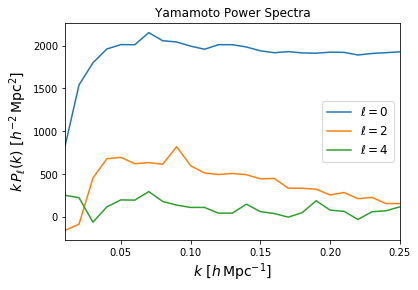

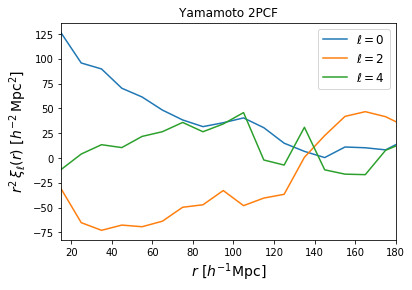

In [8]:
#### Plot spectra

plt.plot(k_av,k_av*result['power0_0'].real,label=r'$\ell=0$')
plt.plot(k_av,k_av*result['power0_2'].real,label=r'$\ell=2$')
plt.plot(k_av,k_av*result['power0_4'].real,label=r'$\ell=4$')
plt.xlabel(r'$k$ [$h\,\mathrm{Mpc}^{-1}$]',fontsize=14)
plt.ylabel(r'$k\,P_\ell(k)$ [$h^{-2}\,\mathrm{Mpc}^{2}$]',fontsize=14)
plt.legend(fontsize=12);
plt.xlim([0.01,0.25]);
plt.title('Yamamoto Power Spectra')

plt.figure()
plt.plot(r_av,r_av**2.*result_xi['corr0_0'],label=r'$\ell=0$')
plt.plot(r_av,r_av**2.*result_xi['corr0_2'],label=r'$\ell=2$')
plt.plot(r_av,r_av**2.*result_xi['corr0_4'],label=r'$\ell=4$')
plt.xlabel(r'$r$ [$h^{-1}\mathrm{Mpc}$]',fontsize=14)
plt.ylabel(r'$r^2\,\xi_\ell(r)$ [$h^{-2}\,\mathrm{Mpc}^{2}$]',fontsize=14)
plt.legend(fontsize=12);
plt.xlim([15,180]);
plt.title('Yamamoto 2PCF');

### 4) Compute Bisector Estimates

In [9]:
print("\n4: COMPUTE BISECTOR ESTIMATES\n");

# Load in coefficient matrix (ordering [ell,m,k,J1,J2,S,coeff])
coeffs = np.loadtxt('/projects/QUIJOTE/Oliver/beyond_yama/ylm_coeffs_bisector.txt')

time_bis = time.time();
# first compute all required FTs
ft_delta_JM = []
ct = 0
for J in range(0,l_max+k_bis_max+1):
    ft_tmp = []
    for M in range(-J,J+1):
        ft_tmp.append(ft(diff*Y_lm_grid[J][J+M])*MAS_mat)
        ct+=1
    ft_delta_JM.append(ft_tmp)
print("Computed %d weighted density fields after %.2f seconds"%(ct,time.time()-time_bis))

# Iterate over all k
for k in range(k_bis_max+1):

    # pick out coefficients
    coeffs2 = coeffs[coeffs[:,2]==k]

    for ell in range(0,l_max+1,2):
        print('Using ell = %d'%ell)
        coeffs3 = coeffs2[coeffs2[:,0]==ell]

        tmp_int = 0.
        tmp_int_xi = 0.

        for m in range(-ell,ell+1):
            coeffs4 = coeffs3[coeffs3[:,1]==m]

            # sum over all the intermediates
            tmp_sum = 0.
            for i in range(len(coeffs4)):
                J1 = int(coeffs4[i][3])
                J2 = int(coeffs4[i][4])
                S = int(coeffs4[i][5])
                weight = coeffs4[i][6]
                # compute Sum FT[delta Y_J1^S](-k)FT[delta Y_J2^{m-S}](k)
                tmp_sum += weight*ft_delta_JM[J1][J1-S].conj()*(-1.)**S*ft_delta_JM[J2][J2+m-S]

            # now compute the spectrum
            tmp_int += tmp_sum*Yk_lm_3D[ell][ell+m].conj()
            tmp_int_xi += ift(tmp_sum)*YDelta_lm_grid[ell][ell+m].conj()

        # Now add k-space binning
        pk_ell = binned(4.*np.pi*norm*tmp_int)
        xi_ell = binned_xi(4.*np.pi*norm*tmp_int_xi)

        result['power%d_%dbis'%(k,ell)] = pk_ell
        result_xi['corr%d_%dbis'%(k,ell)] = xi_ell

        print("Computed bisector spectra with k = %d, ell = %d after %.2f seconds"%(k,ell,time.time()-time_bis))


4: COMPUTE BISECTOR ESTIMATES

Computed 49 weighted density fields after 7.91 seconds
Using ell = 0
Computed bisector spectra with k = 0, ell = 0 after 8.30 seconds
Using ell = 2
Computed bisector spectra with k = 0, ell = 2 after 11.08 seconds
Using ell = 4
Computed bisector spectra with k = 0, ell = 4 after 20.62 seconds
Using ell = 0
Computed bisector spectra with k = 1, ell = 0 after 20.78 seconds
Using ell = 2
Computed bisector spectra with k = 1, ell = 2 after 26.69 seconds
Using ell = 4
Computed bisector spectra with k = 1, ell = 4 after 47.74 seconds
Using ell = 0
Computed bisector spectra with k = 2, ell = 0 after 47.92 seconds
Using ell = 2
Computed bisector spectra with k = 2, ell = 2 after 59.58 seconds
Using ell = 4
Computed bisector spectra with k = 2, ell = 4 after 103.24 seconds


### 5) Compute Midpoint Estimates

In [ ]:
print("\n4: COMPUTE MIDPOINT ESTIMATES\n")

# Load in coefficient matrix (ordering [ell,m,alpha,J1,J2,M,coeff])
coeffs_even = np.loadtxt('/projects/QUIJOTE/Oliver/beyond_yama/ylm_coeffs_midpoint_even.txt')
coeffs_all = np.loadtxt('/projects/QUIJOTE/Oliver/beyond_yama/ylm_coeffs_midpoint_all.txt')

# Load in legendre coefficient matrix (ordering [ell,alpha,J,coeff])
coeffs_leg_even = np.loadtxt('/projects/QUIJOTE/Oliver/beyond_yama/leg_coeffs_midpoint_even.txt')
coeffs_leg_all = np.loadtxt('/projects/QUIJOTE/Oliver/beyond_yama/leg_coeffs_midpoint_all.txt')

# Iterate over all non-trivial alpha
for alpha in range(1,alpha_max+1,1):

    if (-1.)**alpha==1:
        even = True # even parity
    else:
        even = False # odd parity

    ### First compute g^alpha_JM functions for all J, M required
    g_alpha_JM = []

    # Iterate over J  up to maximum required
    for J_i,J in enumerate(range(0,l_max+alpha+1,1)): # use both parity

        # we don't need alpha+J = odd terms
        g_alpha_JM_tmp = []
        if (-1.)**(alpha+J)==-1:
            g_alpha_JM.append([])
            continue

        for M_i in range(2*J+1):

            # Compute h^alpha_lm = FT[delta * Ylm(r) / (2r)^alpha]
            ft_delta_Ylm_r = ft(diff*Y_lm_grid[J][M_i]*(2.*r_all)**(-alpha))*MAS_mat

            # Compute IFT[h^alpha_lm(k) delta*(k)](Delta)
            this_g_alpha = (-1.)**J*ift(ft_delta_Ylm_r*diff_k_conj)

            g_alpha_JM_tmp.append(this_g_alpha)

        g_alpha_JM.append(g_alpha_JM_tmp)

    print("Computed g^alpha_JM contributions for alpha = %d"%alpha)

    # Select required coupling coefficients
    coeffs2 = coeffs_all[coeffs_all[:,2]==alpha]
    coeffs2l = coeffs_leg_all[coeffs_leg_all[:,1]==alpha]
    if even:
        coeffs2e = coeffs_even[coeffs_even[:,2]==alpha]
        coeffs2le = coeffs_leg_even[coeffs_leg_even[:,1]==alpha]

    ### Now combine into spectra for ell>=2
    for l_i,ell in enumerate(range(0,l_max+1,2)):
        if ell==0: continue

        # CORRELATION FUNCTION

        this_coeffl = coeffs2l[coeffs2l[:,0]==ell]
        Fell_xi = 0.
        if even:
            this_coeffle = coeffs2le[coeffs2le[:,0]==ell]
            Fell_xi_even = 0.

        # Select relevant coefficients and iterate over them
        for i in range(len(this_coeffl)):
            J,weight = this_coeffl[i][2:]
            J = int(J)
            if weight==0: continue

            # Sum to hold Sum_M g^alpha_JM(Delta) Y_J^M*(Delta)
            FellJ = 0.

            # Now iterate over M
            for M_i in range(2*J+1):
                FellJ += g_alpha_JM[J][M_i]*YDelta_lm_grid[J][M_i].conj()

            # Now add [ f^{alpha,ell}_J Sum_M g^alpha_JM(Delta) Delta^alpha Y_J^M*(Delta) ] to sum
            Fell_xi += weight*Delta_all**alpha*FellJ

        if even:

            # Select relevant coefficients and iterate over them
            for i in range(len(this_coeffle)):
                J,weight = this_coeffle[i][2:]
                J = int(J)
                if weight==0: continue

                # Sum to hold Sum_M g^alpha_JM(Delta) Y_J^M*(Delta)
                FellJ = 0.

                # Now iterate over M
                for M_i in range(2*J+1):
                    FellJ += g_alpha_JM[J][M_i]*YDelta_lm_grid[J][M_i].conj()

                # Now add [ f^{alpha,ell}_J Sum_M g^alpha_JM(Delta) Delta^alpha Y_J^M*(Delta) ] to sum
                Fell_xi_even += weight*Delta_all**alpha*FellJ

        # Bin and store result
        result_xi['corr%d_%d'%(alpha,ell)] = binned_xi(4.*np.pi*norm*Fell_xi)
        if even:
            result_xi['corr%d_%de'%(alpha,ell)] = binned_xi(4.*np.pi*norm*Fell_xi_even)

        print("2PCF computed for alpha = %d, ell = %d after %.1f seconds"%(alpha,ell,time.time()-start))

        # POWER SPECTRA

        Fell = 0.
        coeffs3 = coeffs2[coeffs2[:,0]==ell]
        if even:
            Fell_even = 0.
            coeffs3e = coeffs2e[coeffs2e[:,0]==ell]

        for m_i, m in enumerate(np.arange(-ell,ell+1,1)):

            this_coeff = coeffs3[coeffs3[:,1]==m]
            if even:
                this_coeffe = coeffs3e[coeffs3e[:,1]==m]

            f_Delta = 0. # array to hold Sum_{alpha,J1,J2,M} phi^{alpha,lm}_{J1J2M} Y_J1M(Delta) g^alpha_J2(m-M)(Delta)

            # Select relevant coefficients and iterate over them
            for i in range(len(this_coeff)):
                j1,j2,M,weight = this_coeff[i][3:]
                j1 = int(j1)
                j2 = int(j2)
                M = int(M)
                mM = m-M
                if abs(mM)>j2:
                    continue
                if weight==0:
                    continue
                f_Delta += weight*g_alpha_JM[j2][j2+mM]*(Delta_all**alpha)*YDelta_lm_grid[j1][j1+M]

            # Now take FT and apply spherical harmonic factor
            Fell += ft(f_Delta)*Yk_lm_3D[ell][ell+m].conj()

            # Repeat for even-parity summations
            if even:
                f_Delta_even = 0.

                for i in range(len(this_coeffe)):
                    j1,j2,M,weight = this_coeffe[i][3:]
                    j1 = int(j1)
                    j2 = int(j2)
                    M = int(M)
                    mM = m-M
                    if abs(mM)>j2:
                        continue
                    if weight==0:
                        continue
                    f_Delta_even += weight*g_alpha_JM[j2][j2+mM]*(Delta_all**alpha)*YDelta_lm_grid[j1][j1+M]

                Fell_even += ft(f_Delta_even)*Yk_lm_3D[ell][ell+m].conj()

        result['power%d_%d'%(alpha,ell)] = binned(4.*np.pi*norm*Fell)
        if even:
            result['power%d_%de'%(alpha,ell)] = binned(4.*np.pi*norm*Fell_even)
        print("Power spectrum computed for alpha = %d, ell = %d after %.1f seconds\n"%(alpha,ell,time.time()-start))


4: COMPUTE MIDPOINT ESTIMATES

Computed g^alpha_JM contributions for alpha = 1
2PCF computed for alpha = 1, ell = 2 after 115.2 seconds
Power spectrum computed for alpha = 1, ell = 2 after 118.0 seconds

2PCF computed for alpha = 1, ell = 4 after 119.8 seconds
Power spectrum computed for alpha = 1, ell = 4 after 124.7 seconds

Computed g^alpha_JM contributions for alpha = 2
2PCF computed for alpha = 2, ell = 2 after 143.5 seconds
Power spectrum computed for alpha = 2, ell = 2 after 155.3 seconds

2PCF computed for alpha = 2, ell = 4 after 160.4 seconds
Power spectrum computed for alpha = 2, ell = 4 after 184.8 seconds

Computed g^alpha_JM contributions for alpha = 3
2PCF computed for alpha = 3, ell = 2 after 209.8 seconds
Power spectrum computed for alpha = 3, ell = 2 after 249.3 seconds

2PCF computed for alpha = 3, ell = 4 after 254.0 seconds
Power spectrum computed for alpha = 3, ell = 4 after 344.2 seconds

Computed g^alpha_JM contributions for alpha = 4
2PCF computed for alpha = 

In [ ]:
for ell in [2,4]:
    plt.figure();
    plt.title(r'$P_\ell(k)$, $\ell=%d$'%ell,fontsize=14)
    plt.plot(k_av,k_av*np.abs(result['power0_%d'%ell]),c='r',label='Yamamoto')
    plt.plot(k_av,k_av*np.abs(result['power1_%dbis'%ell]),c='b',ls='--',label=r'Bisector: $\theta^2$')
    plt.plot(k_av,k_av*np.abs(result['power2_%dbis'%ell]),c='b',ls=':',label=r'Bisector: $\theta^4$')
    plt.plot(k_av,k_av*np.abs(result['power2_%d'%ell]+result['power1_%d'%ell]),c='k',ls='--',label=r'Midpoint (All): $\theta^2$')
    plt.plot(k_av,k_av*np.abs(result['power4_%d'%ell]+result['power3_%d'%ell]),c='k',ls=':',label=r'Midpoint (All): $\theta^4$')
    plt.plot(k_av,k_av*np.abs(result['power2_%de'%ell]),c='g',ls='--',label=r'Midpoint (Even): $\theta^2$')
    plt.plot(k_av,k_av*np.abs(result['power4_%de'%ell]),c='g',ls=':',label=r'Midpoint (Even): $\theta^4$')
    plt.xlim([0.01,0.25])
    plt.xlabel(r'$k$ [$h\,\mathrm{Mpc}^{-1}$]',fontsize=14)
    plt.ylabel(r'$k\,P_\ell(k)$ [$h^{-2}\,\mathrm{Mpc}^{2}$]',fontsize=14)
    plt.legend(fontsize=12,bbox_to_anchor=(1.,.5));
    plt.yscale('log')

    plt.figure();
    plt.title(r'$\xi_\ell(r)$, $\ell=%d$'%ell,fontsize=14)
    plt.plot(r_av,r_av**2*np.abs(result_xi['corr0_%d'%ell]),c='r',label='Yamamoto')
    plt.plot(r_av,r_av**2*np.abs(result_xi['corr1_%dbis'%ell]),c='b',ls='--',label=r'Bisector: $\theta^2$')
    plt.plot(r_av,r_av**2*np.abs(result_xi['corr2_%dbis'%ell]),c='b',ls=':',label=r'Bisector: $\theta^4$')
    plt.plot(r_av,r_av**2*np.abs(result_xi['corr2_%d'%ell]+result_xi['corr1_%d'%ell]),c='k',ls='--',label=r'Midpoint (All): $\theta^2$')
    plt.plot(r_av,r_av**2*np.abs(result_xi['corr4_%d'%ell]+result_xi['corr3_%d'%ell]),c='k',ls=':',label=r'Midpoint (All): $\theta^4$')
    plt.plot(r_av,r_av**2*np.abs(result_xi['corr2_%de'%ell]),c='g',ls='--',label=r'Midpoint (Even): $\theta^2$')
    plt.plot(r_av,r_av**2*np.abs(result_xi['corr4_%de'%ell]),c='g',ls=':',label=r'Midpoint (Even): $\theta^4$')
    plt.xlim([15,185])
    plt.xlabel(r'$r$ [$h^{-1}\mathrm{Mpc}$]',fontsize=14)
    plt.ylabel(r'$r^2\,\xi_\ell(r)$ [$h^{-2}\,\mathrm{Mpc}^{2}$]',fontsize=14)
    plt.legend(fontsize=12,bbox_to_anchor=(1.,.5));
    plt.yscale('log')